# Twitter Sentiment Analysis

Authors: Jeonwook Kang, Mendy Nemanow, Zach Hanly

## Overview
We used twitter data in order to build a model that performs sentiment analysis. The data we used can be found here and was previously labeled with sentiments by other contributors. From those contributors of the data set:

>"Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion."

## Business and Data Understanding
Companies always want to have feedback from customers, and are constantly sending out surveys. In todays day and age, we believe the best feedback you can get from people is them talking about your product online, since it is less formal and you don't need to spend time asking costumers to take surveys. 


We created a model which can help companies analyze tweets about their company and products. this will help the social media department filter through tweets that reference their company and/or their products and find potentially negative tweets so that they may then address them and kepp their costumers happy. 

For this reason we set our model to proioritize identifying the negative tweets.

In [1]:
# import all necessary libraries
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import re
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from wordcloud import WordCloud

## Data Cleaning

We got this data from data.world

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns for my sanity 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

In [4]:
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [5]:
df.sentiment.value_counts()

No emotion toward brand or product    5389
positive                              2978
negative                               570
I can't tell                           156
Name: sentiment, dtype: int64

In [6]:
negative_df = df[df.sentiment == 'negative']

In [7]:
sw = stopwords.words('english')
for word in ['sxsw', 'mention', 'ipad', 'google', 'apple', 'iphone', 'android']:
    sw.append(word)

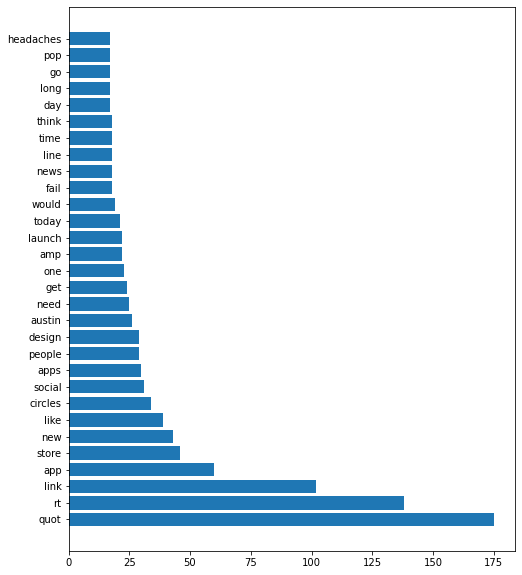

In [8]:
cv = CountVectorizer(stop_words=sw)
negative_words = cv.fit_transform(negative_df.text)
negative_cv = pd.DataFrame(negative_words.toarray(), columns=cv.get_feature_names())
negative_common = list(negative_cv.sum().sort_values(ascending=False)[:50].index)
plt.figure(figsize=(8,10))
plt.barh(negative_cv.sum().sort_values(ascending=False)[:30].index, negative_cv.sum().sort_values(ascending=False)[:30]);


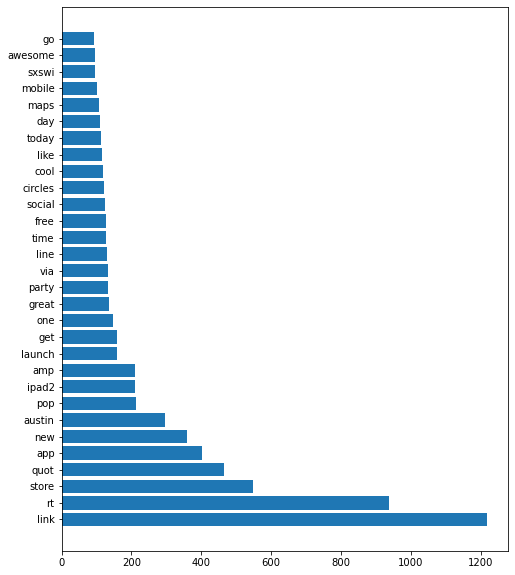

In [9]:
positive_df = df[df.sentiment == 'positive']
cv = CountVectorizer(stop_words=sw)
positive_words = cv.fit_transform(positive_df.text)
positive_cv = pd.DataFrame(positive_words.toarray(), columns=cv.get_feature_names())
positive_common = list(positive_cv.sum().sort_values(ascending=False)[:500].index)

plt.figure(figsize=(8,10))
plt.barh(positive_cv.sum().sort_values(ascending=False)[:30].index, positive_cv.sum().sort_values(ascending=False)[:30]);

In [10]:
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(' '.join(negative_common))


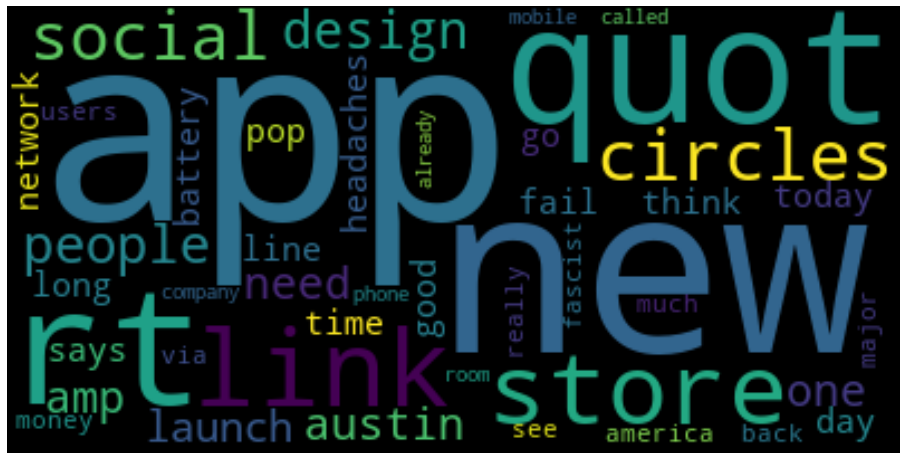

In [11]:
plt.figure(figsize=(16,16))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
negative_common = [ element for element in list(negative_cv.sum().sort_values(ascending=False)[:100].index)
     if element not in list(positive_cv.sum().sort_values(ascending=False)[:500].index)] 

positive_common = [ element for element in list(positive_cv.sum().sort_values(ascending=False)[:100].index) 
    if element not in list(negative_cv.sum().sort_values(ascending=False)[:500].index)] 

In [13]:
print('Common words found in negative tweets and not in positive:', negative_common)
print('')
print('')
print('Common words found in positive tweets and not in negative:', positive_common)

Common words found in negative tweets and not in positive: ['fail', 'headaches', 'america', 'money', 'fascist', 'instead', 'vs', 'gave', 'hate', 'needs', 'nothing', 'diller', 'fades', 'delegates', 'among']


Common words found in positive tweets and not in negative: ['free', 'downtown', 'popup', 'wins', 'win', 'video', 'fun', 'shop', 'smart', 'comes', 'set', 'team', 'case', 'begins', 'marketing', 'week', 'conferences']
